<a href="https://colab.research.google.com/github/wizard339/education/blob/main/misis/nlp/text_classification/transfer_learning_nlp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import torchtext
import gensim.downloader
from torch.utils.data import DataLoader
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.types import Device
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset
from prompt_toolkit import output
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

## Loading data, EDA, data preprocessing

### Loading data

In [2]:
train_raw_data = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/text_classification/train.csv', index_col=0)
final_test_raw_data = pd.read_csv(filepath_or_buffer='https://raw.githubusercontent.com/wizard339/education/main/misis/nlp/text_classification/test.csv')

print(f'Shape of train: {train_raw_data.shape}')
print(f'Shape of test: {final_test_raw_data.shape}')

Shape of train: (41159, 2)
Shape of test: (3798, 2)


### Working with missing data

Let's look at the data:


In [3]:
train_raw_data.head()

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41159 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41158 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 964.7+ KB


We can see that there are rows with missing data. Let's look at them:

In [5]:
train_raw_data[train_raw_data['Sentiment'].isnull() == True]

,Text,Sentiment
33122,@PrivyCouncilCA #SocialDistancing isnÂt enoug...,NaN
NaN,Neutral,NaN
39204,@TanDhesi @foreignoffice @Afzal4Gorton @Expres...,NaN
Neutral,NaN,NaN


Let's drop these rows from our DataFrame because they don't carry much value and let's look at the data again:

In [6]:
train_raw_data = train_raw_data.dropna().reset_index(drop=True)
print(f'New shape of train: {train_raw_data.shape}')

New shape of train: (41155, 2)


In [7]:
train_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41155 entries, 0 to 41154
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       41155 non-null  object
 1   Sentiment  41155 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


Let's look at the lines of texts:

(array([ 530., 3268., 4924., 6560., 6257., 7495., 8516., 3053.,  529.,
          23.]),
 array([ 1. ,  7.3, 13.6, 19.9, 26.2, 32.5, 38.8, 45.1, 51.4, 57.7, 64. ]),
 <BarContainer object of 10 artists>)

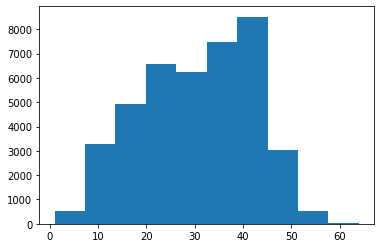

In [8]:
plt.hist([len(text.split()) for text in train_raw_data['Text']])

(array([ 24., 231., 356., 477., 543., 623., 701., 629., 199.,  15.]),
 array([ 2.,  8., 14., 20., 26., 32., 38., 44., 50., 56., 62.]),
 <BarContainer object of 10 artists>)

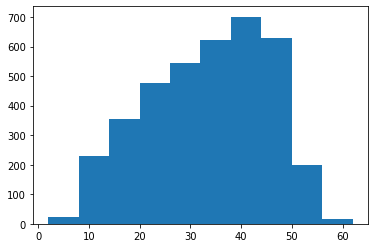

In [9]:
plt.hist([len(text.split()) for text in final_test_raw_data['Text']])

There are no sequences that are too long and the distributions in the training and test samples are similar. It is good.

### Label encoding of target column

In [10]:
train_raw_data['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [11]:
le = LabelEncoder()
le.fit(train_raw_data['Sentiment'])
train_raw_data['Sentiment'] = le.transform(train_raw_data['Sentiment'])
train_raw_data.head(5)

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,3
1,advice Talk to your neighbours family to excha...,4
2,Coronavirus Australia: Woolworths to give elde...,4
3,My food stock is not the only one which is emp...,4
4,"Me, ready to go at supermarket during the #COV...",0


### Сleaning text from useless data

Let's look at the text more closely:

In [12]:
train_raw_data['Text'].sample(10, random_state=42).values

array(['So panic buying of soaps and toilet roll was bad enough, now the idiots are stockpiling alcohol ? whats wrong with people #CoronaVirus #StopPanicBuying #Covid_19',
       'I would place a large amount of money this is the guy buying 90 of the toilet paper',
       '"Saudi Arabia is bracing for an economic downturn as oil prices plummet due to the #coronavirus pandemic" https://t.co/PQ3eRX9euZ',
       '#Foodsecurity #coronavirus #covid19 \r\r\n1.Smooth flow of global trade will help secure food supply\r\r\n2.Monitoring food prices and markets\r\r\n3.Sharing relevant information transparently\r\r\n4.Supporting the vulnerable countries and populationsÂ\x85https://t.co/tTPmInVVgS https://t.co/Ums3Eueu6J',
       'I d like to know who is stockpiling eggs cheese and ice cream and why I m used to going without as our local Lidl has been running out of all kinds of stuff for years way before Drives me potty Going to the supermarket is like entering a lottery',
       'Whenever you tou

In [13]:
def text_cleaner(text: str) -> str:
    '''will clean from unicode, url, hashtags, numbers,
    nicknames, lower'''
    # text = re.sub(r'[.,#!$%\^&\*;:{}=\-_`~()]',r'',text) # punct.
    
    # text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]', r'', text)# unicode

    # text = re.sub(r'\\[a-z]', r'', text)
    
    text = re.sub(r'http\S+', r'', text)# url
    
    text = re.sub('@[A-Za-z0-9_-]+', r'', text)# nickname
    
    text = re.sub(r'#([^\s]+)', r'\1', text)# hashtag symbol
    
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:',
                  '', text) # emoji
    
    text = ''.join([i for i in text if not i.isdigit()])# int.
    
    text = text.lower()
    return text

In [14]:
train_raw_data['Text'] = train_raw_data['Text'].apply(text_cleaner)
final_test_raw_data['Text'] = final_test_raw_data['Text'].apply(text_cleaner)
train_raw_data['Text'].sample(10, random_state=42).values

array(['so panic buying of soaps and toilet roll was bad enough, now the idiots are stockpiling alcohol ? whats wrong with people coronavirus stoppanicbuying covid_',
       'i would place a large amount of money this is the guy buying  of the toilet paper',
       '"saudi arabia is bracing for an economic downturn as oil prices plummet due to the coronavirus pandemic" ',
       'foodsecurity coronavirus covid \r\r\n.smooth flow of global trade will help secure food supply\r\r\n.monitoring food prices and markets\r\r\n.sharing relevant information transparently\r\r\n.supporting the vulnerable countries and populations ',
       'i d like to know who is stockpiling eggs cheese and ice cream and why i m used to going without as our local lidl has been running out of all kinds of stuff for years way before drives me potty going to the supermarket is like entering a lottery',
       'whenever you touch any object or surface outside your abode washyourhands with soapandwater\r\r\n\r\r\nstay

### Tokenization

In [15]:
tokenizer = get_tokenizer('basic_english')

def build_vocabulary(datasets):
  for dataset in datasets:
    for text in dataset['Text']:
      yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_raw_data, final_test_raw_data]), specials=['<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

In [16]:
print(f'Vocabulary length: {vocab.__len__()}')

Vocabulary length: 50653


### Splitting of training data

We need to split our train_raw_data by train, validation and test samples in the proportions of 60:20:20.

However, our data contain texts for 5 classes, so it is necessary to keep stratification after their splitting.

In [17]:
# first, we will split data by two samples: train and test in the proportion of 60:40
train_data, test_data = train_test_split(train_raw_data, test_size=0.2, stratify=train_raw_data['Sentiment'], random_state=42)
# then, we will split test data by two samples: validation and test in the proportion of 50:50 
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['Sentiment'], random_state=42)

Check the stratification:

In [18]:
train_raw_data['Sentiment'].value_counts(normalize=True)

4    0.277536
2    0.240967
3    0.187365
1    0.160952
0    0.133179
Name: Sentiment, dtype: float64

In [19]:
train_data['Sentiment'].value_counts(normalize=True)

4    0.277518
2    0.240979
3    0.187371
1    0.160946
0    0.133186
Name: Sentiment, dtype: float64

In [20]:
val_data['Sentiment'].value_counts(normalize=True)

4    0.277521
2    0.240826
3    0.187363
1    0.161118
0    0.133171
Name: Sentiment, dtype: float64

In [21]:
test_data['Sentiment'].value_counts(normalize=True)

4    0.277697
2    0.241011
3    0.187318
1    0.160836
0    0.133139
Name: Sentiment, dtype: float64

In [22]:
print(f'Shape of the train_data: {train_data.shape}')
print(f'Shape of the val_data: {val_data.shape}')
print(f'Shape of the test_data: {test_data.shape}')
print(f'Shape of the finel_test_raw_data: {final_test_raw_data.shape}')

Shape of the train_data: (32924, 2)
Shape of the val_data: (4115, 2)
Shape of the test_data: (4116, 2)
Shape of the finel_test_raw_data: (3798, 2)


### Creating datasets

In [33]:
train_dataset, val_dataset, test_dataset, final_test_dataset = to_map_style_dataset(train_data.values), \
                                                               to_map_style_dataset(val_data.values), \
                                                               to_map_style_dataset(test_data.values), \
                                                               to_map_style_dataset(final_test_raw_data.values)

MAX_WORDS  = 60
BATCH_SIZE = 1024

def vectorize_batch(batch):
  X, Y = list(zip(*batch))
  X = [vocab(tokenizer(text)) for text in X] # tokenize and map tokens to indexes
  X = [tokens+([0]*(MAX_WORDS - len(tokens))) if len(tokens) < MAX_WORDS else tokens[:MAX_WORDS] for tokens in X]
  return torch.tensor(X, dtype=torch.int32, device='cpu'), torch.tensor(Y, device='cpu')


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
val_loader  = DataLoader(val_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
final_test_loader  = DataLoader(final_test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch)

In [34]:
from prompt_toolkit import output
from torch import nn
from torch.nn import functional as F

EMBED_LEN  = 50
HIDDEN_DIM = 75
N_LAYERS   = 1

target_classes = train_raw_data['Sentiment'].unique()

class LSTMClassifier(nn.Module):
  def __init__(self):
    super(LSTMClassifier, self).__init__()
    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, batch_first=True)
    self.fc = nn.Linear(in_features=HIDDEN_DIM, out_features=len(target_classes))
    # self.drop = nn.Dropout(p=0.5)
    

  def forward(self, X_batch):
    emb = self.emb_layer(X_batch)
    output, (h, c) = self.lstm(emb)
    # output = self.drop(output)
    return self.fc(output[:, -1])

In [35]:
lstm_classifier = LSTMClassifier()

lstm_classifier

LSTMClassifier(
  (emb_layer): Embedding(50653, 50)
  (lstm): LSTM(50, 75, batch_first=True)
  (fc): Linear(in_features=75, out_features=5, bias=True)
)

In [36]:
for layer in lstm_classifier.children():
  print(f'Layer: {layer}')
  print('Parameters: ')
  for param in layer.parameters():
    print(param.shape)
  print()

Layer: Embedding(50653, 50)
Parameters: 
torch.Size([50653, 50])

Layer: LSTM(50, 75, batch_first=True)
Parameters: 
torch.Size([300, 50])
torch.Size([300, 75])
torch.Size([300])
torch.Size([300])

Layer: Linear(in_features=75, out_features=5, bias=True)
Parameters: 
torch.Size([5, 75])
torch.Size([5])



In [37]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
  with torch.no_grad():
    Y_shuffled, Y_preds, losses = [], [], []
    for X, Y in val_loader:
      preds = model(X)
      loss = loss_fn(preds, Y)
      losses.append(loss.item())

      Y_shuffled.append(Y)
      Y_preds.append(preds.argmax(dim=-1))

    Y_shuffled = torch.cat(Y_shuffled)
    Y_preds = torch.cat(Y_preds)

    print(f'Valid Loss: {torch.tensor(losses).cpu().mean():.3f}')
    print(f'Valid Acc : {accuracy_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy()):.3f}')


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, device, epochs=10):

  for i in range(1, epochs+1):
    losses = []
    for X, Y in tqdm(train_loader):
      X.to(device)
      Y.to(device)
      model.to(device)

      Y_preds = model(X)

      loss = loss_fn(Y_preds, Y)
      losses.append(loss.item())

      optimizer.zero_grad()

      loss.backward()
      optimizer.step()


    print(f'Train Loss: {torch.tensor(losses).mean():.3f}')
    CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [39]:
from torch.optim import Adam

EPOCHS  = 10
LR      = 1e-2
OPT     = Adam(lstm_classifier.parameters(), lr=LR)
LOSS_FN = nn.CrossEntropyLoss()

TrainModel(model=lstm_classifier, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS)

100%|██████████| 33/33 [00:22<00:00,  1.44it/s]


Train Loss: 1.578
Valid Loss: 1.552
Valid Acc : 0.262


100%|██████████| 33/33 [00:22<00:00,  1.49it/s]


Train Loss: 1.535
Valid Loss: 1.499
Valid Acc : 0.316


100%|██████████| 33/33 [00:22<00:00,  1.50it/s]


Train Loss: 1.456
Valid Loss: 1.435
Valid Acc : 0.346


100%|██████████| 33/33 [00:22<00:00,  1.46it/s]


Train Loss: 1.297
Valid Loss: 1.334
Valid Acc : 0.394


100%|██████████| 33/33 [00:22<00:00,  1.45it/s]


Train Loss: 1.168
Valid Loss: 1.294
Valid Acc : 0.430


100%|██████████| 33/33 [00:25<00:00,  1.32it/s]


Train Loss: 1.060
Valid Loss: 1.328
Valid Acc : 0.474


100%|██████████| 33/33 [00:27<00:00,  1.18it/s]


Train Loss: 0.949
Valid Loss: 1.341
Valid Acc : 0.523


100%|██████████| 33/33 [00:22<00:00,  1.49it/s]


Train Loss: 0.741
Valid Loss: 1.151
Valid Acc : 0.589


100%|██████████| 33/33 [00:27<00:00,  1.21it/s]


Train Loss: 0.560
Valid Loss: 1.162
Valid Acc : 0.607


100%|██████████| 33/33 [00:26<00:00,  1.26it/s]


Train Loss: 0.430
Valid Loss: 1.202
Valid Acc : 0.619


In [46]:
from prompt_toolkit import output
from torch import nn
from torch.nn import functional as F

EMBED_LEN  = 50
HIDDEN_DIM = 75
N_LAYERS   = 1

target_classes = train_raw_data['Sentiment'].unique()

class LSTMClassifier2(nn.Module):
  def __init__(self):
    super(LSTMClassifier2, self).__init__()
    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(in_features=HIDDEN_DIM*2, out_features=len(target_classes))
    # self.drop = nn.Dropout(p=0.5)
    

  def forward(self, X_batch):
    emb = self.emb_layer(X_batch)
    output, (h, c) = self.lstm(emb)
    # output = self.drop(output)
    return self.fc(output[:, -1])


lstm_classifier2 = LSTMClassifier2()

EPOCHS  = 10
LR      = 1e-2
OPT     = Adam(lstm_classifier2.parameters(), lr=LR)
LOSS_FN = nn.CrossEntropyLoss()

TrainModel(model=lstm_classifier2, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS)

100%|██████████| 33/33 [00:47<00:00,  1.45s/it]


Train Loss: 1.580
Valid Loss: 1.570
Valid Acc : 0.278


100%|██████████| 33/33 [00:49<00:00,  1.50s/it]


Train Loss: 1.555
Valid Loss: 1.523
Valid Acc : 0.308


100%|██████████| 33/33 [00:44<00:00,  1.34s/it]


Train Loss: 1.458
Valid Loss: 1.442
Valid Acc : 0.359


100%|██████████| 33/33 [00:43<00:00,  1.31s/it]


Train Loss: 1.289
Valid Loss: 1.366
Valid Acc : 0.426


100%|██████████| 33/33 [00:45<00:00,  1.37s/it]


Train Loss: 1.139
Valid Loss: 1.275
Valid Acc : 0.494


100%|██████████| 33/33 [00:44<00:00,  1.34s/it]


Train Loss: 0.997
Valid Loss: 1.248
Valid Acc : 0.529


100%|██████████| 33/33 [00:43<00:00,  1.33s/it]


Train Loss: 0.811
Valid Loss: 1.046
Valid Acc : 0.607


100%|██████████| 33/33 [00:44<00:00,  1.35s/it]


Train Loss: 0.588
Valid Loss: 0.959
Valid Acc : 0.662


100%|██████████| 33/33 [00:44<00:00,  1.34s/it]


Train Loss: 0.436
Valid Loss: 1.051
Valid Acc : 0.661


100%|██████████| 33/33 [00:42<00:00,  1.28s/it]


Train Loss: 0.340
Valid Loss: 0.937
Valid Acc : 0.678


In [47]:
from prompt_toolkit import output
from torch import nn
from torch.nn import functional as F

EMBED_LEN  = 50
HIDDEN_DIM = 75
N_LAYERS   = 1

target_classes = train_raw_data['Sentiment'].unique()

class LSTMClassifier3(nn.Module):
  def __init__(self):
    super(LSTMClassifier3, self).__init__()
    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, batch_first=True)
    self.fc = nn.Linear(in_features=HIDDEN_DIM, out_features=len(target_classes))
    self.drop = nn.Dropout(p=0.4)
    

  def forward(self, X_batch):
    emb = self.emb_layer(X_batch)
    output, (h, c) = self.lstm(emb)
    output = self.drop(output)
    return self.fc(output[:, -1])


lstm_classifier3 = LSTMClassifier3()

EPOCHS  = 10
LR      = 1e-2
OPT     = Adam(lstm_classifier3.parameters(), lr=LR)
LOSS_FN = nn.CrossEntropyLoss()

TrainModel(model=lstm_classifier3, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS)

100%|██████████| 33/33 [00:20<00:00,  1.58it/s]


Train Loss: 1.582
Valid Loss: 1.559
Valid Acc : 0.278


100%|██████████| 33/33 [00:21<00:00,  1.52it/s]


Train Loss: 1.575
Valid Loss: 1.575
Valid Acc : 0.279


100%|██████████| 33/33 [00:22<00:00,  1.44it/s]


Train Loss: 1.558
Valid Loss: 1.556
Valid Acc : 0.293


100%|██████████| 33/33 [00:21<00:00,  1.52it/s]


Train Loss: 1.504
Valid Loss: 1.448
Valid Acc : 0.328


100%|██████████| 33/33 [00:21<00:00,  1.54it/s]


Train Loss: 1.367
Valid Loss: 1.336
Valid Acc : 0.380


100%|██████████| 33/33 [00:21<00:00,  1.52it/s]


Train Loss: 1.212
Valid Loss: 1.282
Valid Acc : 0.466


100%|██████████| 33/33 [00:20<00:00,  1.63it/s]


Train Loss: 1.069
Valid Loss: 1.225
Valid Acc : 0.526


100%|██████████| 33/33 [00:21<00:00,  1.55it/s]


Train Loss: 0.826
Valid Loss: 1.066
Valid Acc : 0.595


100%|██████████| 33/33 [00:21<00:00,  1.53it/s]


Train Loss: 0.609
Valid Loss: 1.065
Valid Acc : 0.657


100%|██████████| 33/33 [00:22<00:00,  1.46it/s]


Train Loss: 0.461
Valid Loss: 0.960
Valid Acc : 0.659


In [48]:
from prompt_toolkit import output
from torch import nn
from torch.nn import functional as F

EMBED_LEN  = 50
HIDDEN_DIM = 256
N_LAYERS   = 1

target_classes = train_raw_data['Sentiment'].unique()

class LSTMClassifier4(nn.Module):
  def __init__(self):
    super(LSTMClassifier4, self).__init__()
    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, batch_first=True)
    self.fc = nn.Linear(in_features=HIDDEN_DIM, out_features=len(target_classes))
    self.drop = nn.Dropout(p=0.4)
    

  def forward(self, X_batch):
    emb = self.emb_layer(X_batch)
    output, (h, c) = self.lstm(emb)
    output = self.drop(output)
    return self.fc(output[:, -1])


lstm_classifier4 = LSTMClassifier4()

EPOCHS  = 10
LR      = 1e-2
OPT     = Adam(lstm_classifier4.parameters(), lr=LR)
LOSS_FN = nn.CrossEntropyLoss()

TrainModel(model=lstm_classifier4, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS)

100%|██████████| 33/33 [01:43<00:00,  3.15s/it]


Train Loss: 1.627
Valid Loss: 1.569
Valid Acc : 0.265


100%|██████████| 33/33 [01:45<00:00,  3.19s/it]


Train Loss: 1.576
Valid Loss: 1.563
Valid Acc : 0.279


100%|██████████| 33/33 [01:55<00:00,  3.49s/it]


Train Loss: 1.563
Valid Loss: 1.537
Valid Acc : 0.287


 85%|████████▍ | 28/33 [01:32<00:16,  3.31s/it]


KeyboardInterrupt: ignored

In [49]:
from prompt_toolkit import output
from torch import nn
from torch.nn import functional as F

EMBED_LEN  = 50
HIDDEN_DIM = 75
N_LAYERS   = 1

target_classes = train_raw_data['Sentiment'].unique()

class LSTMClassifier5(nn.Module):
  def __init__(self):
    super(LSTMClassifier5, self).__init__()
    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, batch_first=True, bidirectional=True)
    self.fc = nn.Linear(in_features=HIDDEN_DIM*2, out_features=len(target_classes))
    self.drop = nn.Dropout(p=0.4)
    

  def forward(self, X_batch):
    emb = self.emb_layer(X_batch)
    output, (h, c) = self.lstm(emb)
    output = self.drop(output)
    return self.fc(output[:, -1])


lstm_classifier5 = LSTMClassifier5()

EPOCHS  = 15
LR      = 1e-2
OPT     = Adam(lstm_classifier5.parameters(), lr=LR)
LOSS_FN = nn.CrossEntropyLoss()

TrainModel(model=lstm_classifier5, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS)

100%|██████████| 33/33 [00:48<00:00,  1.48s/it]


Train Loss: 1.582
Valid Loss: 1.559
Valid Acc : 0.278


100%|██████████| 33/33 [00:47<00:00,  1.45s/it]


Train Loss: 1.574
Valid Loss: 1.602
Valid Acc : 0.279


100%|██████████| 33/33 [00:47<00:00,  1.44s/it]


Train Loss: 1.572
Valid Loss: 1.559
Valid Acc : 0.278


100%|██████████| 33/33 [00:47<00:00,  1.45s/it]


Train Loss: 1.531
Valid Loss: 1.586
Valid Acc : 0.295


100%|██████████| 33/33 [00:46<00:00,  1.41s/it]


Train Loss: 1.441
Valid Loss: 1.442
Valid Acc : 0.346


100%|██████████| 33/33 [00:45<00:00,  1.39s/it]


Train Loss: 1.276
Valid Loss: 1.308
Valid Acc : 0.409


100%|██████████| 33/33 [00:46<00:00,  1.40s/it]


Train Loss: 1.141
Valid Loss: 1.360
Valid Acc : 0.432


100%|██████████| 33/33 [00:45<00:00,  1.39s/it]


Train Loss: 1.037
Valid Loss: 1.346
Valid Acc : 0.457


100%|██████████| 33/33 [00:46<00:00,  1.40s/it]


Train Loss: 0.929
Valid Loss: 1.301
Valid Acc : 0.501


100%|██████████| 33/33 [00:47<00:00,  1.43s/it]


Train Loss: 0.767
Valid Loss: 1.366
Valid Acc : 0.546


100%|██████████| 33/33 [00:46<00:00,  1.42s/it]


Train Loss: 0.614
Valid Loss: 1.485
Valid Acc : 0.575


100%|██████████| 33/33 [00:46<00:00,  1.42s/it]


Train Loss: 0.461
Valid Loss: 1.254
Valid Acc : 0.600


100%|██████████| 33/33 [00:46<00:00,  1.42s/it]


Train Loss: 0.352
Valid Loss: 1.292
Valid Acc : 0.610


100%|██████████| 33/33 [00:47<00:00,  1.44s/it]


Train Loss: 0.289
Valid Loss: 1.480
Valid Acc : 0.622


100%|██████████| 33/33 [00:49<00:00,  1.49s/it]


Train Loss: 0.249
Valid Loss: 1.329
Valid Acc : 0.617


In [59]:
def MakePredictions(model, loader, device):
  Y_shuffled, Y_preds= [], []
  for X, Y in loader:
    X.to(device)
    Y.to(device)
    preds = model(X)
    Y_preds.append(preds)
    Y_shuffled.append(Y)
  gc.collect()
  Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

  return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1)

Y_actual, Y_preds = MakePredictions(lstm_classifier, test_loader, device)

In [61]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

target_classes = le.inverse_transform(target_classes)
print(f'Test Accuracy: {accuracy_score(Y_actual, Y_preds)}')
print('\nClassification report: ')
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print('\nConfusion Matrix: ')
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy: 0.6967930029154519

Classification report: 
                    precision    recall  f1-score   support

           Neutral       0.74      0.63      0.68       548
          Positive       0.76      0.74      0.75       662
Extremely Negative       0.61      0.65      0.63       992
          Negative       0.84      0.70      0.76       771
Extremely Positive       0.65      0.74      0.69      1143

          accuracy                           0.70      4116
         macro avg       0.72      0.69      0.70      4116
      weighted avg       0.71      0.70      0.70      4116


Confusion Matrix: 
[[346   6 182   2  12]
 [  3 487   7   0 165]
 [104  18 649  45 176]
 [  6  11 111 540 103]
 [ 10 120 112  55 846]]


# Model 2

In [25]:
import gensim.downloader

pretrained_embeddings = gensim.downloader.load('fasttext-wiki-news-subwords-300')

[=================================================-] 99.7% 955.4/958.4MB downloaded


In [26]:
pretrained_vectors = torch.tensor(pretrained_embeddings.vectors)

In [31]:
EMBED_LEN  = 300
HIDDEN_DIM = 75
N_LAYERS   = 1

target_classes = train_raw_data['Sentiment'].unique()

class LSTMClassifier2(nn.Module):
  def __init__(self):
    super(LSTMClassifier2, self).__init__()
    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, batch_first=True)
    self.fc = nn.Linear(in_features=HIDDEN_DIM, out_features=len(target_classes))
    self.drop = nn.Dropout(p=0.5)
    self.init_embeds()

  def init_embeds(self):
    weights = pretrained_vectors
    self.emb_layer = nn.Embedding.from_pretrained(weights, freeze=False)

  def forward(self, X_batch):
    emb = self.emb_layer(X_batch)
    output, (h, c) = self.lstm(emb)
    # output = self.drop(output)
    return self.drop(self.fc(output[:, -1]))

In [32]:
lstm_classifier2 = LSTMClassifier2()
lstm_classifier2

LSTMClassifier2(
  (emb_layer): Embedding(999999, 300)
  (lstm): LSTM(300, 75, batch_first=True)
  (fc): Linear(in_features=75, out_features=5, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [38]:
EPOCHS  = 10
LR      = 1e-3
OPT     = Adam(lstm_classifier2.parameters(), lr=LR)
LOSS_FN = nn.CrossEntropyLoss()

TrainModel(model=lstm_classifier2, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS)

100%|██████████| 33/33 [03:07<00:00,  5.69s/it]


Train Loss: 1.593
Valid Loss: 1.573
Valid Acc : 0.243


100%|██████████| 33/33 [03:05<00:00,  5.63s/it]


Train Loss: 1.591
Valid Loss: 1.584
Valid Acc : 0.246


100%|██████████| 33/33 [03:13<00:00,  5.87s/it]


Train Loss: 1.586
Valid Loss: 1.587
Valid Acc : 0.246


  0%|          | 0/33 [00:05<?, ?it/s]


KeyboardInterrupt: ignored

In [131]:
EPOCHS  = 10
LR      = 1e-2
OPT     = Adam(lstm_classifier2.parameters(), lr=LR)
LOSS_FN = nn.NLLLoss(reduction='sum')

TrainModel(model=lstm_classifier2, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS)

100%|██████████| 33/33 [00:47<00:00,  1.43s/it]


Train Loss: -104925.234
Valid Loss: -86003.016
Valid Acc : 0.561


100%|██████████| 33/33 [00:45<00:00,  1.37s/it]


Train Loss: -127157.031
Valid Loss: -102956.828
Valid Acc : 0.580


 15%|█▌        | 5/33 [00:07<00:41,  1.48s/it]


KeyboardInterrupt: ignored

In [120]:
from torch.autograd import Variable


EMBED_LEN  = 50
HIDDEN_DIM = 75
N_LAYERS   = 1


class LSTMClassifier3(nn.Module):
  def __init__(self):
    super(LSTMClassifier3, self).__init__()
    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, batch_first=True)
    self.fc = nn.Linear(in_features=HIDDEN_DIM, out_features=len(target_classes))
    # self.drop = nn.Dropout(p=0.2)
    self.softmax = nn.LogSoftmax(dim=1)
    self.hidden = self.init_hidden()

  def init_hidden(self):
    h0 = Variable(torch.zeros(N_LAYERS, 1024, HIDDEN_DIM))
    c0 = Variable(torch.zeros(N_LAYERS, 1024, HIDDEN_DIM))
    hidden = (h0, c0)
    return hidden

  def forward(self, X_batch, hidden):
    # self.hidden = self.init_hidden(X_batch.shape[0])
    emb = self.emb_layer(X_batch)
    output, self.hidden = self.lstm(emb, self.hidden)
    output = output[:,-1,:]
    output = self.fc(output)
    output = self.softmax(output)
    return output, self.hidden

In [121]:
lstm_classifier3 = LSTMClassifier3()
lstm_classifier3

LSTMClassifier3(
  (emb_layer): Embedding(50615, 50)
  (lstm): LSTM(50, 75, batch_first=True)
  (fc): Linear(in_features=75, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [122]:
EPOCHS  = 10
LR      = 1e-2
OPT     = Adam(lstm_classifier3.parameters(), lr=LR)
LOSS_FN = nn.CrossEntropyLoss()

TrainModel(model=lstm_classifier3, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS)

  0%|          | 0/33 [00:00<?, ?it/s]


TypeError: ignored

In [125]:
from torch.autograd import Variable


EMBED_LEN  = 50
HIDDEN_DIM = 75
N_LAYERS   = 1


class LSTMClassifier4(nn.Module):
  def __init__(self):
    super(LSTMClassifier4, self).__init__()
    self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
    self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, batch_first=True, bidirectional=True)
    self.fc1 = nn.Linear(in_features=HIDDEN_DIM*2, out_features=HIDDEN_DIM)
    self.fc2 = nn.Linear(in_features=HIDDEN_DIM, out_features=len(target_classes))
    self.drop = nn.Dropout(p=0.2)
    # self.init_embeds()

  def init_hidden(self, batch_size):
    h0 = Variable(torch.zeros(N_LAYERS*2, batch_size, HIDDEN_DIM))
    c0 = Variable(torch.zeros(N_LAYERS*2, batch_size, HIDDEN_DIM))
    return h0, c0

  def forward(self, X_batch):
    self.hidden = self.init_hidden(X_batch.shape[0])
    emb = self.emb_layer(X_batch)
    output, self.hidden = self.lstm(emb, self.hidden)
    output = self.fc1(output)
    output = self.drop(self.fc2(output[:, -1]))
    return output

In [126]:
lstm_classifier4 = LSTMClassifier4()
lstm_classifier4

LSTMClassifier4(
  (emb_layer): Embedding(50615, 50)
  (lstm): LSTM(50, 75, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=150, out_features=75, bias=True)
  (fc2): Linear(in_features=75, out_features=5, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

In [127]:
EPOCHS  = 10
LR      = 1e-2
OPT     = Adam(lstm_classifier4.parameters(), lr=LR)
LOSS_FN = nn.CrossEntropyLoss()

TrainModel(model=lstm_classifier4, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader, device=device, epochs=EPOCHS)

100%|██████████| 33/33 [01:23<00:00,  2.54s/it]


Train Loss: 1.588
Valid Loss: 1.586
Valid Acc : 0.269


100%|██████████| 33/33 [01:22<00:00,  2.50s/it]


Train Loss: 1.582
Valid Loss: 1.574
Valid Acc : 0.270


100%|██████████| 33/33 [01:20<00:00,  2.44s/it]


Train Loss: 1.580
Valid Loss: 1.570
Valid Acc : 0.261


 64%|██████▎   | 21/33 [00:55<00:31,  2.65s/it]


KeyboardInterrupt: ignored

In [ ]:
pretrained_embeddings = vocab.vectors